#**End to End west detection Project using yolov5**

In [1]:
!nvidia-smi

Fri Mar  1 07:21:12 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   43C    P8               9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [2]:
# clone YOLOv5 repository
!git clone https://github.com/ultralytics/yolov5.git  # clone repo
%cd yolov5

Cloning into 'yolov5'...
remote: Enumerating objects: 16491, done.
remote: Counting objects: 100% (83/83), done.
remote: Compressing objects: 100% (74/74), done.
remote: Total 16491 (delta 27), reused 36 (delta 9), pack-reused 16408
Receiving objects: 100% (16491/16491), 15.17 MiB | 17.69 MiB/s, done.
Resolving deltas: 100% (11290/11290), done.
/content/yolov5


In [3]:
# install dependencies as necessary
!pip install -qr requirements.txt  # install dependencies (ignore errors)
import torch

from IPython.display import Image, clear_output  # to display images
# from utils.google_utils import gdrive_download  # to download models/datasets

# clear_output()
print('Setup complete. Using torch %s %s' % (torch.__version__, torch.cuda.get_device_properties(0) if torch.cuda.is_available() else 'CPU'))


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 195.4/195.4 kB 6.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 716.3/716.3 kB 15.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 7.6 MB/s eta 0:00:00
Setup complete. Using torch 2.1.0+cu121 _CudaDeviceProperties(name='Tesla T4', major=7, minor=5, total_memory=15102MB, multi_processor_count=40)


In [4]:
pwd

'/content/yolov5'

In [5]:
%cd /content

/content


In [6]:
import gdown

url = "https://drive.google.com/file/d/1ECfl3dtYyfivY8kYPq7RHUBTjC-2vf61/view?usp=share_link"

file_id = url.split("/")[-2]
print(file_id)
prefix = 'https://drive.google.com/uc?/export=download&id='
gdown.download(prefix+file_id)
print("Data downloaded!")

1ECfl3dtYyfivY8kYPq7RHUBTjC-2vf61


Downloading...
From (original): https://drive.google.com/uc?/export=download&id=1ECfl3dtYyfivY8kYPq7RHUBTjC-2vf61
From (redirected): https://drive.google.com/uc?/export=download&id=1ECfl3dtYyfivY8kYPq7RHUBTjC-2vf61&confirm=t&uuid=69ef6924-a279-463f-9f94-23fe204cfc77
To: /content/waste-detection.zip
100%|██████████| 40.1M/40.1M [00:01<00:00, 25.6MB/s]

Data downloaded!


In [7]:
!unzip waste-detection.zip
!rm -rf waste-detection.zip

Archive:  waste-detection.zip
  inflating: data.yaml               
   creating: train/
   creating: train/images/
  inflating: train/images/Banana_10_jpg.rf.7c0536bc9eb72ec77c8f515653f44fb9.jpg  
  inflating: train/images/Banana_11_jpg.rf.188551ec3d51326e5562675d285d0e6a.jpg  
  inflating: train/images/Banana_12_jpg.rf.2ecabc9628a9611963e4804d13045377.jpg  
  inflating: train/images/Banana_12_jpg.rf.e951f9b4b66c9896ce6b7a56f9d41438.jpg  
  inflating: train/images/Banana_15_jpg.rf.09c5d34e95e0c06a808a99533e8e737c.jpg  
  inflating: train/images/Banana_15_jpg.rf.c2909c26fa3140f1734b451bead6752b.jpg  
  inflating: train/images/Banana_15_jpg.rf.e7fb3723604fb753bdbca26f382d7aaf.jpg  
  inflating: train/images/Banana_16_jpg.rf.504aa1c1679f9d595e336eba25f6d80c.jpg  
  inflating: train/images/Banana_16_jpg.rf.73833169c2979508c979f27bcb572959.jpg  
  inflating: train/images/Banana_16_jpg.rf.bd09b3cf6ae33d668a421a48b8c4b34b.jpg  
  inflating: train/images/Banana_16_jpg.rf.dbfad378a52e84709bbb24

In [8]:

# this is the YAML file  we're loading into this notebook with our data
%cat data.yaml

train: ../train/images
val: ../valid/images


nc: 13
names: ['banana', 'chilli', 'drinkcan', 'drinkpack', 'foodcan', 'lettuce', 'paperbag', 'plasticbag', 'plasticbottle', 'plasticcontainer', 'sweetpotato', 'teabag', 'tissueroll']



#Define Model Configuration and Architecture

In [9]:

# define number of classes based on YAML
import yaml
with open("data.yaml", 'r') as stream:
    num_classes = str(yaml.safe_load(stream)['nc'])

In [10]:

num_classes

'13'

In [11]:
#this is the model configuration we will use
%cat /content/yolov5/models/yolov5s.yaml

# YOLOv5 🚀 by Ultralytics, AGPL-3.0 license

# Parameters
nc: 80 # number of classes
depth_multiple: 0.33 # model depth multiple
width_multiple: 0.50 # layer channel multiple
anchors:
  - [10, 13, 16, 30, 33, 23] # P3/8
  - [30, 61, 62, 45, 59, 119] # P4/16
  - [116, 90, 156, 198, 373, 326] # P5/32

# YOLOv5 v6.0 backbone
backbone:
  # [from, number, module, args]
  [
    [-1, 1, Conv, [64, 6, 2, 2]], # 0-P1/2
    [-1, 1, Conv, [128, 3, 2]], # 1-P2/4
    [-1, 3, C3, [128]],
    [-1, 1, Conv, [256, 3, 2]], # 3-P3/8
    [-1, 6, C3, [256]],
    [-1, 1, Conv, [512, 3, 2]], # 5-P4/16
    [-1, 9, C3, [512]],
    [-1, 1, Conv, [1024, 3, 2]], # 7-P5/32
    [-1, 3, C3, [1024]],
    [-1, 1, SPPF, [1024, 5]], # 9
  ]

# YOLOv5 v6.0 head
head: [
    [-1, 1, Conv, [512, 1, 1]],
    [-1, 1, nn.Upsample, [None, 2, "nearest"]],
    [[-1, 6], 1, Concat, [1]], # cat backbone P4
    [-1, 3, C3, [512, False]], # 13

    [-1, 1, Conv, [256, 1, 1]],
    [-1, 1, nn.Upsample, [None, 2, "nearest"]],
    [[-1, 

In [12]:
#customize iPython writefile so we can write variables
from IPython.core.magic import register_line_cell_magic

@register_line_cell_magic
def writetemplate(line, cell):
    with open(line, 'w') as f:
        f.write(cell.format(**globals()))

In [13]:
%%writetemplate /content/yolov5/models/custom_yolov5s.yaml

# parameters
nc: {num_classes}  # number of classes
depth_multiple: 0.33  # model depth multiple
width_multiple: 0.50  # layer channel multiple

# anchors
anchors:
  - [10,13, 16,30, 33,23]  # P3/8
  - [30,61, 62,45, 59,119]  # P4/16
  - [116,90, 156,198, 373,326]  # P5/32

# YOLOv5 backbone
backbone:
  # [from, number, module, args]
  [[-1, 1, Focus, [64, 3]],  # 0-P1/2
   [-1, 1, Conv, [128, 3, 2]],  # 1-P2/4
   [-1, 3, BottleneckCSP, [128]],
   [-1, 1, Conv, [256, 3, 2]],  # 3-P3/8
   [-1, 9, BottleneckCSP, [256]],
   [-1, 1, Conv, [512, 3, 2]],  # 5-P4/16
   [-1, 9, BottleneckCSP, [512]],
   [-1, 1, Conv, [1024, 3, 2]],  # 7-P5/32
   [-1, 1, SPP, [1024, [5, 9, 13]]],
   [-1, 3, BottleneckCSP, [1024, False]],  # 9
  ]

# YOLOv5 head
head:
  [[-1, 1, Conv, [512, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 6], 1, Concat, [1]],  # cat backbone P4
   [-1, 3, BottleneckCSP, [512, False]],  # 13

   [-1, 1, Conv, [256, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 4], 1, Concat, [1]],  # cat backbone P3
   [-1, 3, BottleneckCSP, [256, False]],  # 17 (P3/8-small)

   [-1, 1, Conv, [256, 3, 2]],
   [[-1, 14], 1, Concat, [1]],  # cat head P4
   [-1, 3, BottleneckCSP, [512, False]],  # 20 (P4/16-medium)

   [-1, 1, Conv, [512, 3, 2]],
   [[-1, 10], 1, Concat, [1]],  # cat head P5
   [-1, 3, BottleneckCSP, [1024, False]],  # 23 (P5/32-large)

   [[17, 20, 23], 1, Detect, [nc, anchors]],  # Detect(P3, P4, P5)
  ]


#Train Custom YOLOv5 Detector
Next, we'll fire off training!
Here, we are able to pass a number of arguments:

img: define input image size

batch: determine batch size

epochs: define the number of training epochs.

(Note: often, 3000+ are common here!)

data: set the path to our yaml file

cfg: specify our model configuration

weights: specify a custom path to weights. (Note: you can download weights from the Ultralytics Google Drive folder)

name: result names

nosave: only save the final checkpoint

cache: cache images for faster training

In [14]:
# train yolov5s on custom data for 100 epochs
# time its performance
%%time
%cd /content/yolov5/
!python train.py --img 416 --batch 16 --epochs 50 --data '../data.yaml' --cfg ./models/custom_yolov5s.yaml --weights 'yolov5s.pt' --name yolov5s_results  --cache


/content/yolov5
2024-03-01 07:36:36.002690: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-01 07:36:36.002744: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-01 07:36:36.004086: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
train: weights=yolov5s.pt, cfg=./models/custom_yolov5s.yaml, data=../data.yaml, hyp=data/hyps/hyp.scratch-low.yaml, epochs=50, batch_size=16, imgsz=416, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, evolve_population=data/hyps, resume_evolve=None, bucket=, cache=ram, image_weights=False, devic

#Evaluate Custom YOLOv5 Detector Performance

Training losses and performance metrics are saved to Tensorboard and also to a logfile defined above with the --name flag when we train. In our case, we named this yolov5s_results.
 (If given no name, it defaults to results.txt.) The results file is plotted as a png after training completes.

Note from Glenn: Partially completed results.txt files can be plotted with from utils.utils import plot_results; plot_results().

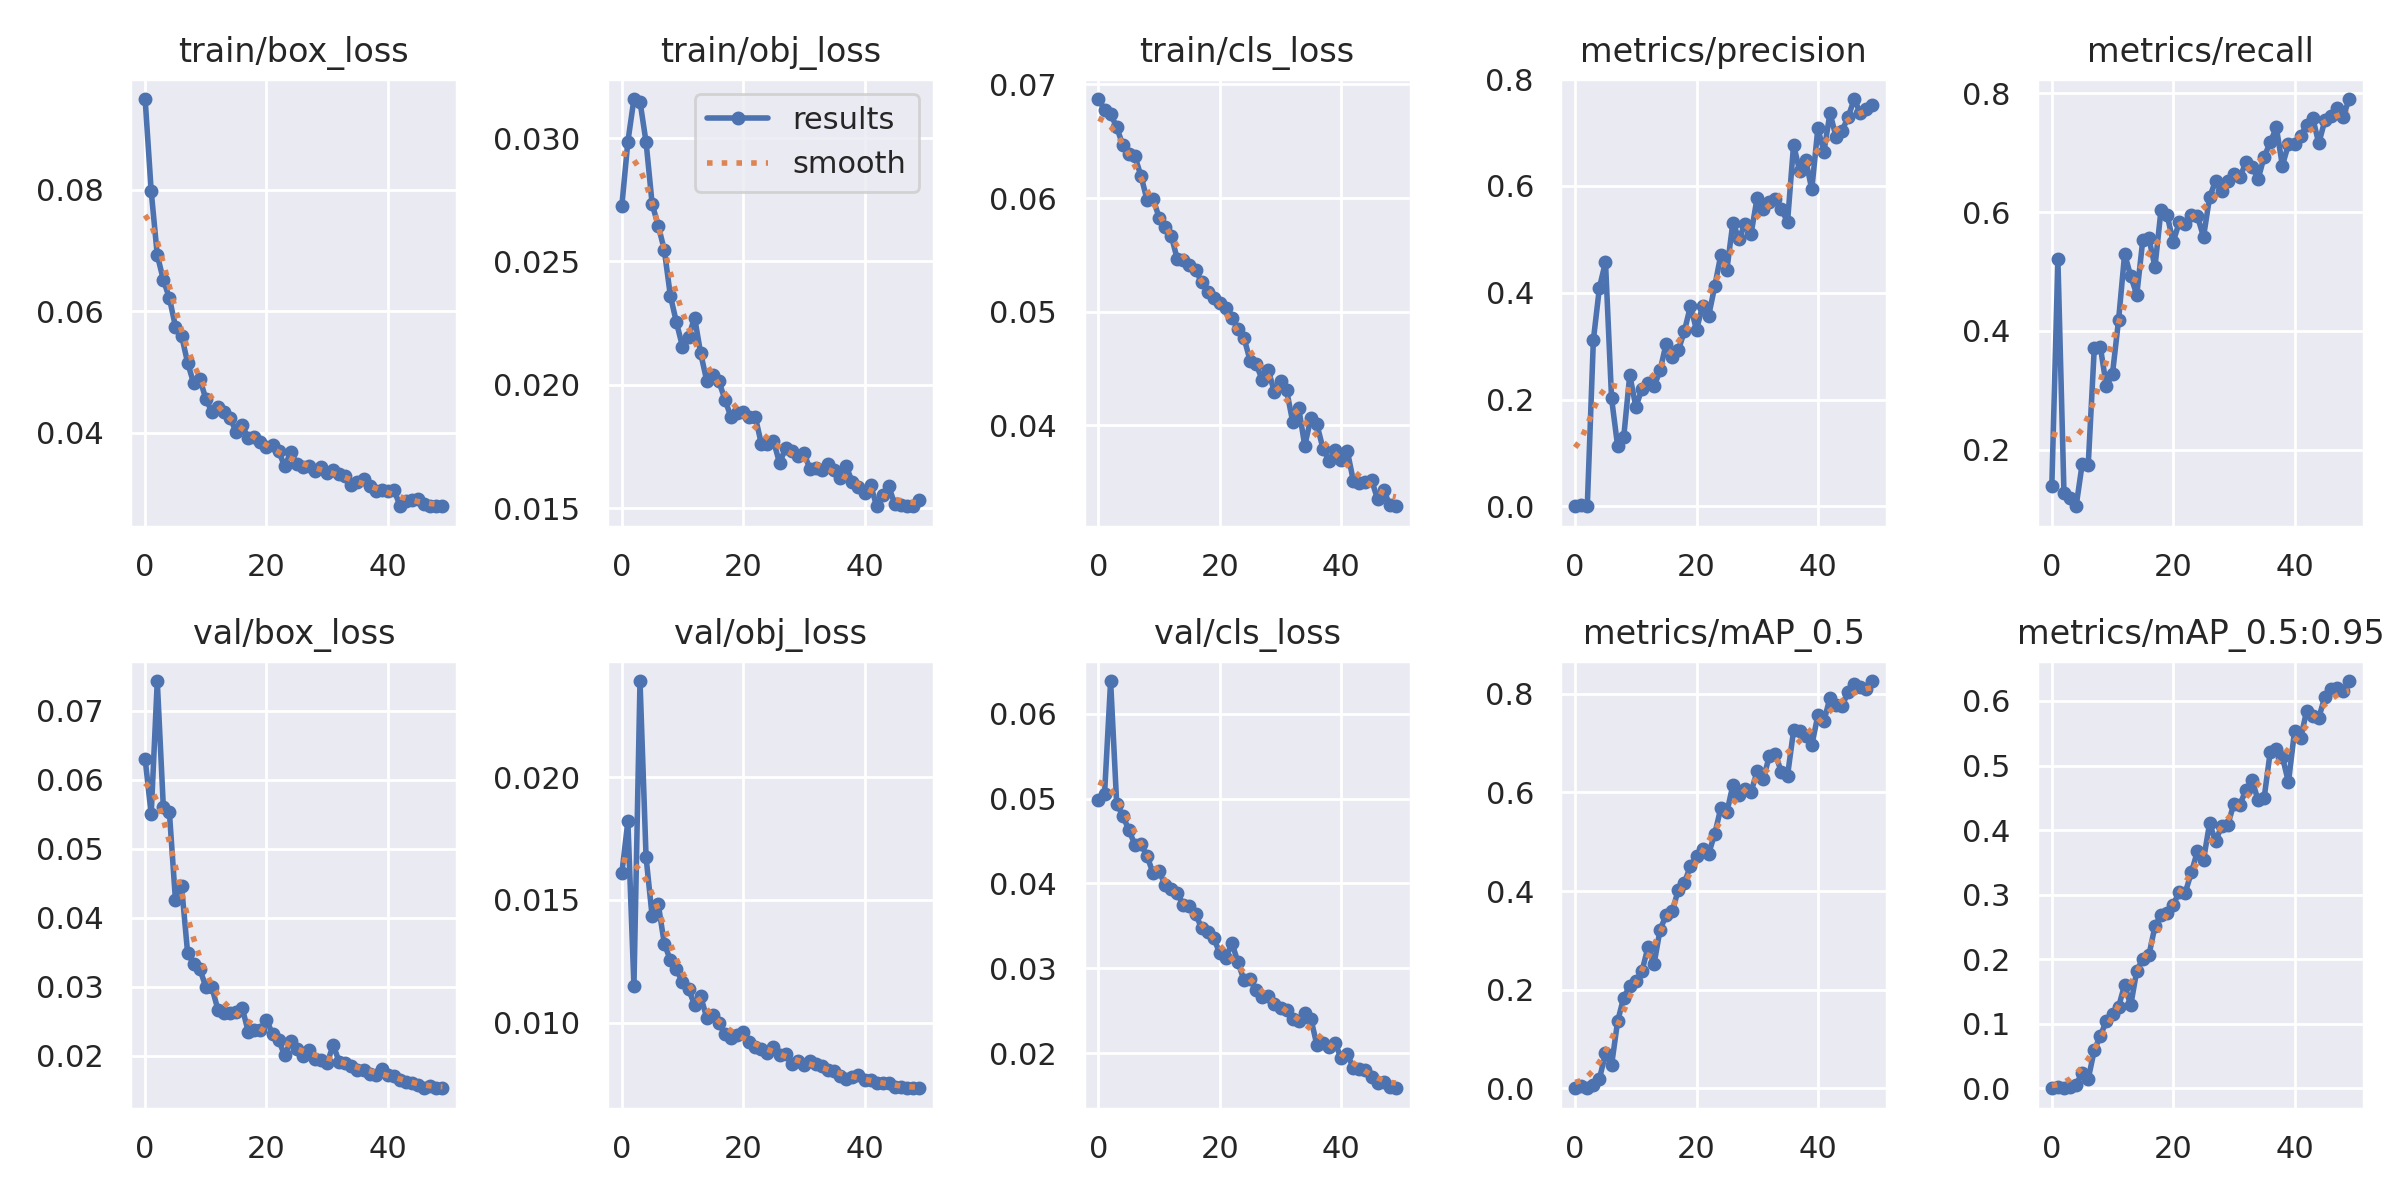

In [16]:
# we can also output some older school graphs if the tensor board isn't working for whatever reason...
from utils.plots import plot_results  # plot results.txt as results.png
Image(filename='/content/yolov5/runs/train/yolov5s_results/results.png', width=1000)  # view results.png

#Curious? Visualize Our Training Data with Labels
After training starts, view train*.jpg images to see training images, labels and augmentation effects.

Note a mosaic dataloader is used for training (shown below), a new dataloading concept developed by Glenn Jocher and first featured in YOLOv4.

GROUND TRUTH TRAINING DATA:


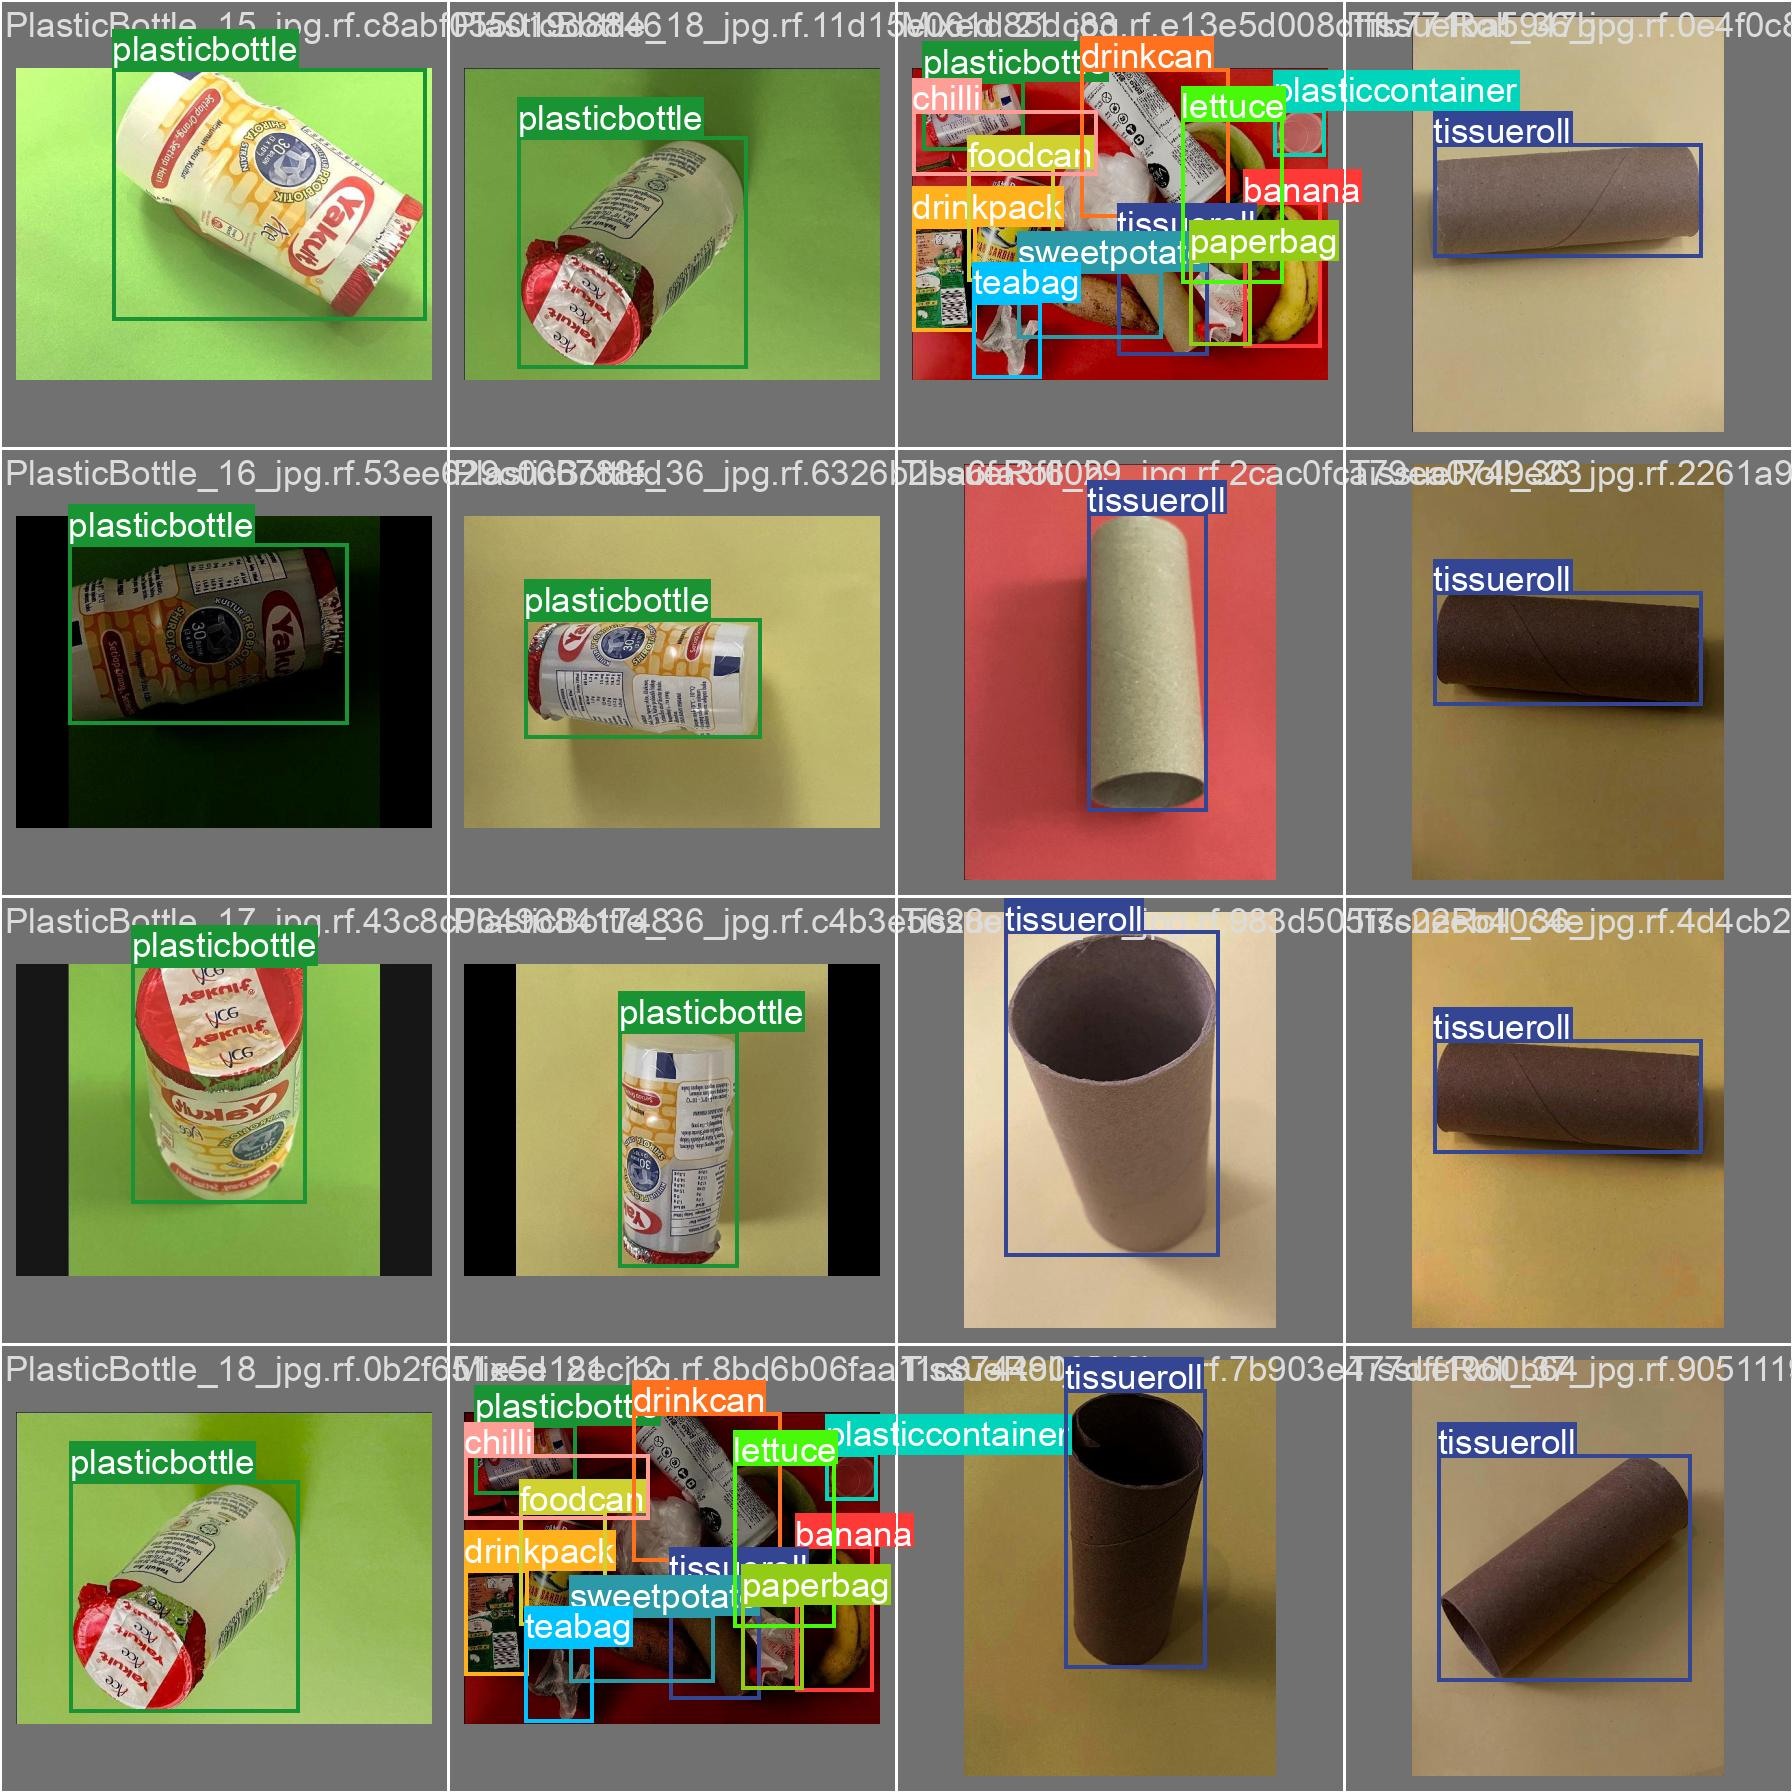

In [17]:
# first, display our ground truth data
print("GROUND TRUTH TRAINING DATA:")
Image(filename='/content/yolov5/runs/train/yolov5s_results/val_batch0_labels.jpg', width=900)

GROUND TRUTH AUGMENTED TRAINING DATA:


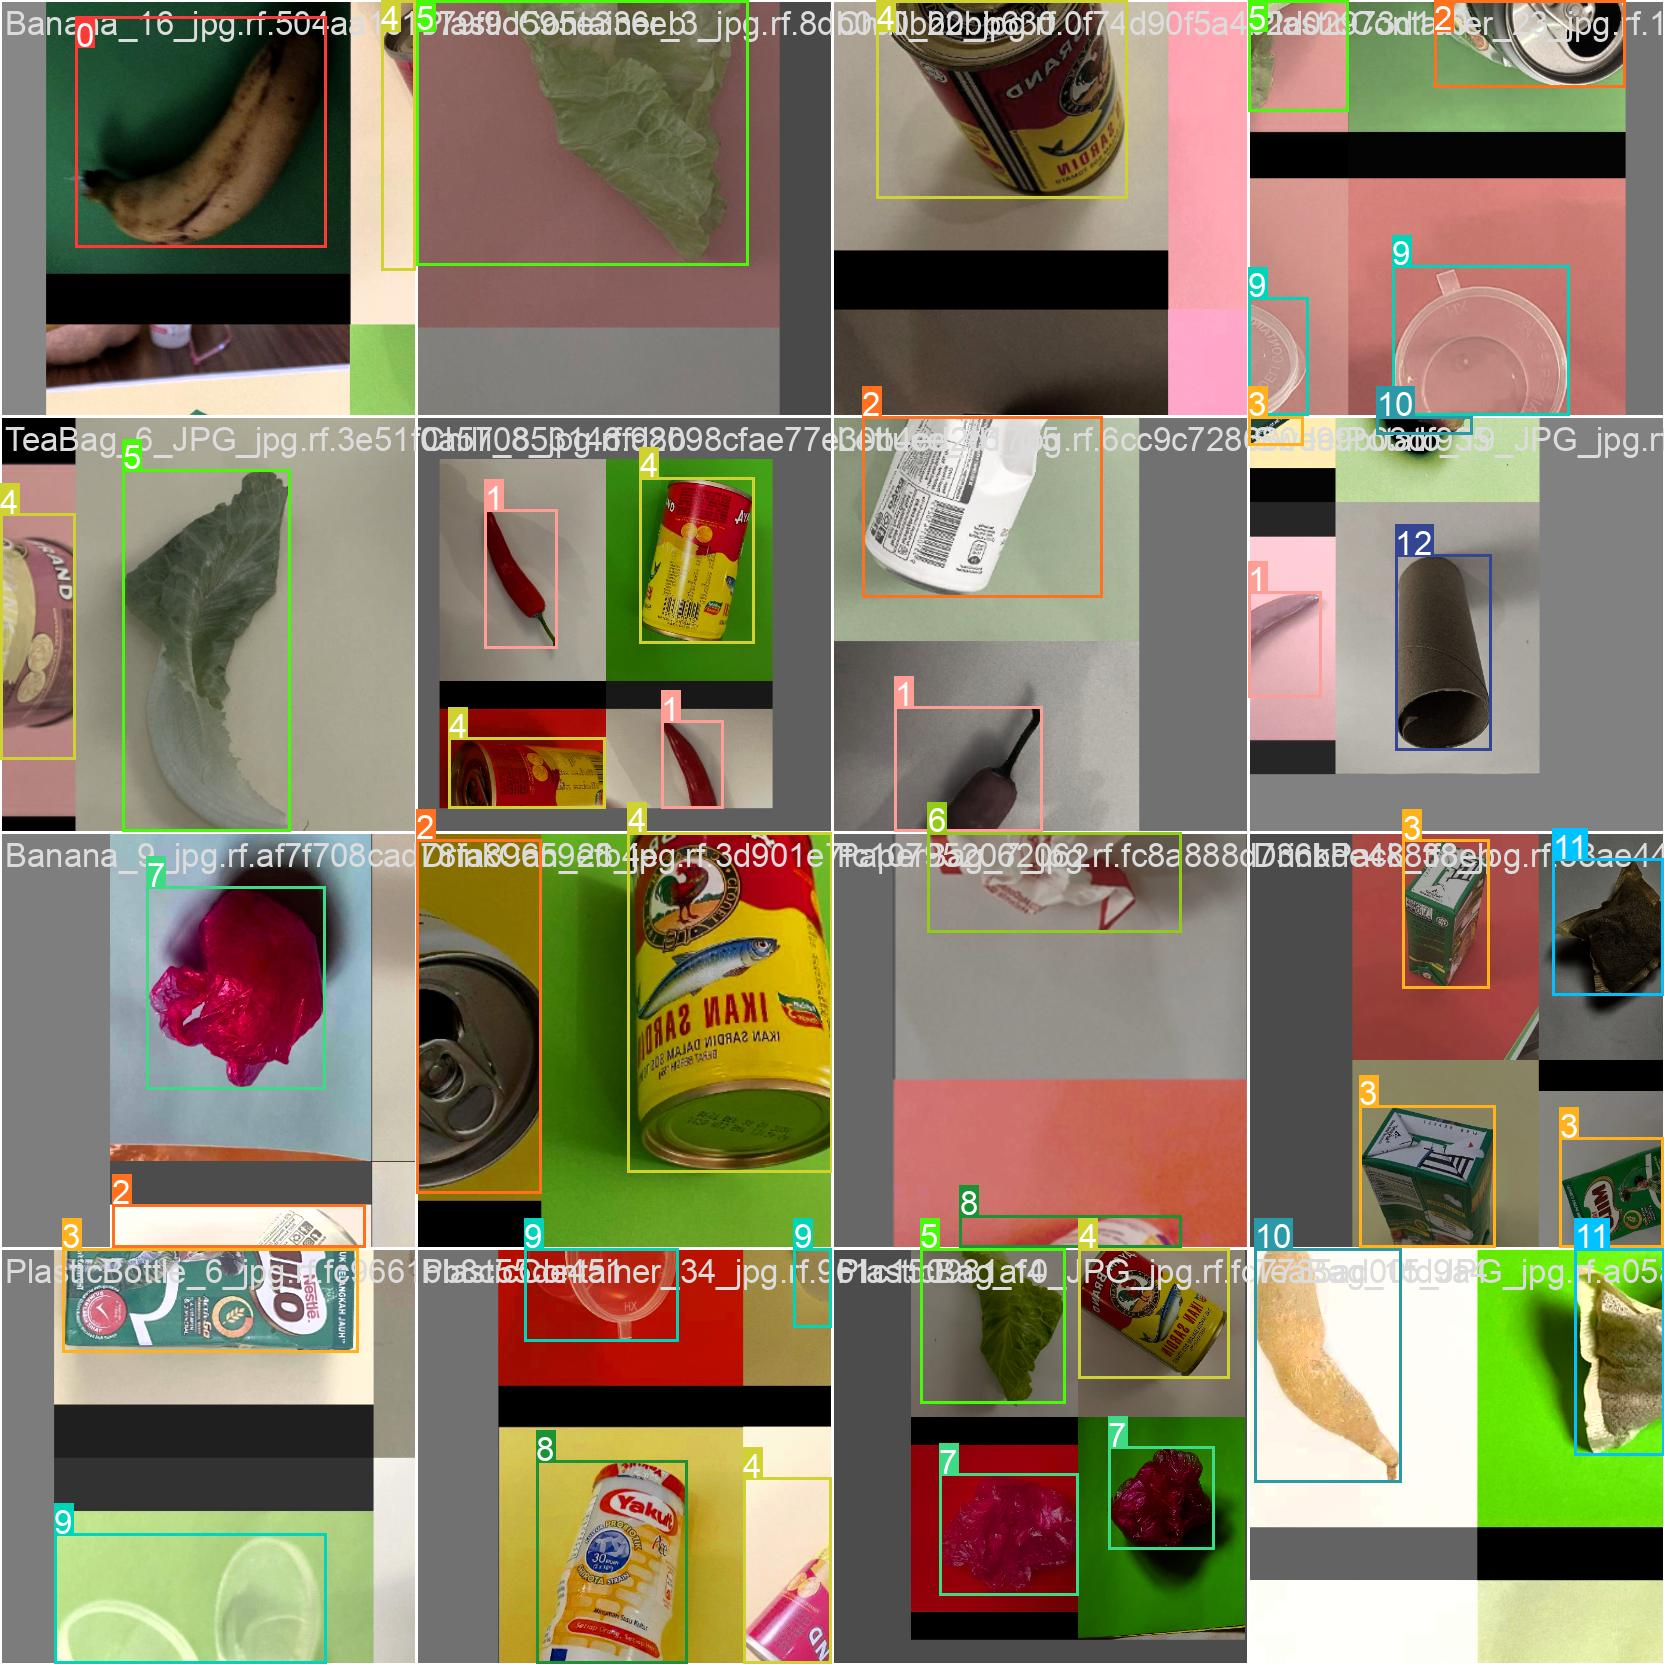

In [18]:
# print out an augmented training example
print("GROUND TRUTH AUGMENTED TRAINING DATA:")
Image(filename='/content/yolov5/runs/train/yolov5s_results/train_batch0.jpg', width=900)


#Run Inference With Trained Weights

In [19]:

# trained weights are saved by default in our weights folder
%ls runs/


train/


In [20]:

%ls runs/train/yolov5s_results/weights

best.pt  last.pt


In [22]:
# when we ran this, we saw .007 second inference time. That is 140 FPS on a TESLA P100!
# use the best weights!
%cd /content/yolov5/
!python detect.py --weights runs/train/yolov5s_results/weights/best.pt --img 416 --conf 0.5 --source ../valid/images

/content/yolov5
detect: weights=['runs/train/yolov5s_results/weights/best.pt'], source=../valid/images, data=data/coco128.yaml, imgsz=[416, 416], conf_thres=0.5, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_csv=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5 🚀 v7.0-287-g574331f9 Python-3.10.12 torch-2.1.0+cu121 CUDA:0 (Tesla T4, 15102MiB)

Fusing layers... 
custom_YOLOv5s summary: 182 layers, 7278882 parameters, 0 gradients
WARNING ⚠️ NMS time limit 0.550s exceeded
image 1/459 /content/valid/images/Banana_10_jpg.rf.0f4f5f5b749f5681048000d59b667d94.jpg: 416x320 1 banana, 50.4ms
image 2/459 /content/valid/images/Banana_10_jpg.rf.5d587c81371bd16a3a5eba3af30ce089.jpg: 416x320 1 banana, 6.9ms
image 3/459 /content/valid/images/Banana_

In [24]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive
